# Import

In [1]:
import csv
import os
import pickle
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm

## Add configuration file

In [2]:
sys.path.append("/home/jovyan/core/config/")
sys.path.append("/home/jovyan/core/util/")
sys.path.append("../PlotFunction/lineplot/")
sys.path.append("../PlotFunction/config/")

In [3]:
from ALL import config
from line_plot_1 import line_plot_1
from line_plot_error_1 import line_plot_error_1
from line_plot_error_1_layout import layout
from util import *

## Set condition

In [4]:
tqdm.pandas()
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 50)

In [5]:
data_type = "20News"
vectorize_type = "sentenceBERT"

# Read data

In [6]:
df = pd.read_csv(
    f"../../Preprocessing/data/{data_type}/master.csv", index_col=0
)

In [7]:
with open(f"../../Preprocessing/data/{data_type}/class.csv", mode="r") as f:
    reader = csv.reader(f)
    class_labels = [label for label in reader]

In [8]:
vector_dims = config["vectorize"]["doc2vec"]["dims"]
model_nums = config["clustering"]["gmm"]["max_model_num"]
vector_model_num = config["vectorize"]["doc2vec"]["max_model_num"]
covariance_types = config["clustering"]["gmm"]["covariance_types"]

In [9]:
stats_vals = ["aic", "bic", "mi", "logl"]

In [10]:
# データ型定義
stats = {
    stats_val: {
        covariance_type: {model_num: pd.DataFrame for model_num in range(model_nums)}
        for covariance_type in covariance_types
    }
    for stats_val in stats_vals
}

# データ取得
for stats_val in stats_vals:
    for covariance_type in covariance_types:
        for model_num in range(model_nums):
            stats_path = f"../../Postprocessing/data/{data_type}/{vectorize_type}/GMM/stats/{covariance_type}/{model_num}.csv"
            df = pd.read_csv(stats_path, index_col=0)
            stats[stats_val][covariance_type][model_num] = df.loc[:, stats_val]

In [11]:
lda_mi = pd.read_csv(f"../../Postprocessing/data/{data_type}/LDA/mi.csv", index_col=0)

In [12]:
describe_lda_mi, _ = get_describe(lda_mi, axis=0)

# Data shaping

In [13]:
stats_df = {
    stats_val: {covariance_type: pd.DataFrame() for covariance_type in covariance_types}
    for stats_val in stats_vals
}

for stats_val in stats_vals:
    for covariance_type in covariance_types:
        # model_numについて取得データstatsを結合
        stats_df[stats_val][covariance_type] = pd.concat(
            stats[stats_val][covariance_type], axis=1
        )

In [14]:
describe = {
    stats_val: {covariance_type: dict() for covariance_type in covariance_types}
    for stats_val in stats_vals
}

for stats_val in stats_vals:
    for covariance_type in covariance_types:
        describe[stats_val][covariance_type], describe_keys = get_describe(
            stats_df[stats_val][covariance_type], axis=1
        )

In [15]:
data = {
    stats_val: {describe_key: pd.DataFrame() for describe_key in describe_keys}
    for stats_val in stats_vals
}
for stats_val in stats_vals:
    for describe_key in describe_keys:
        # covariance_typeについてデータを結合
        _data = {
            covariance_type: describe[stats_val][covariance_type][describe_key]
            for covariance_type in covariance_types
        }
        data[stats_val][describe_key] = pd.concat(_data, axis=1)

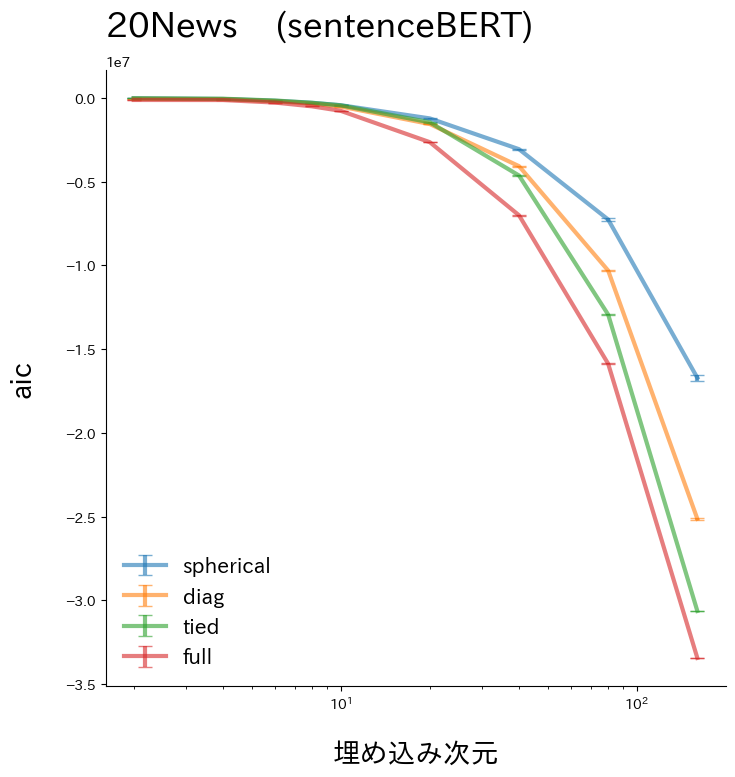

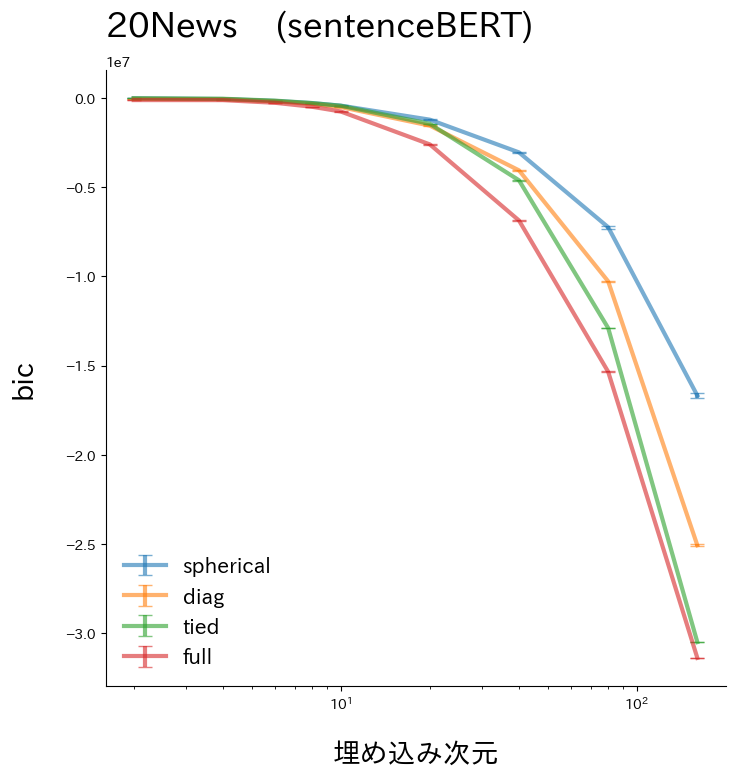

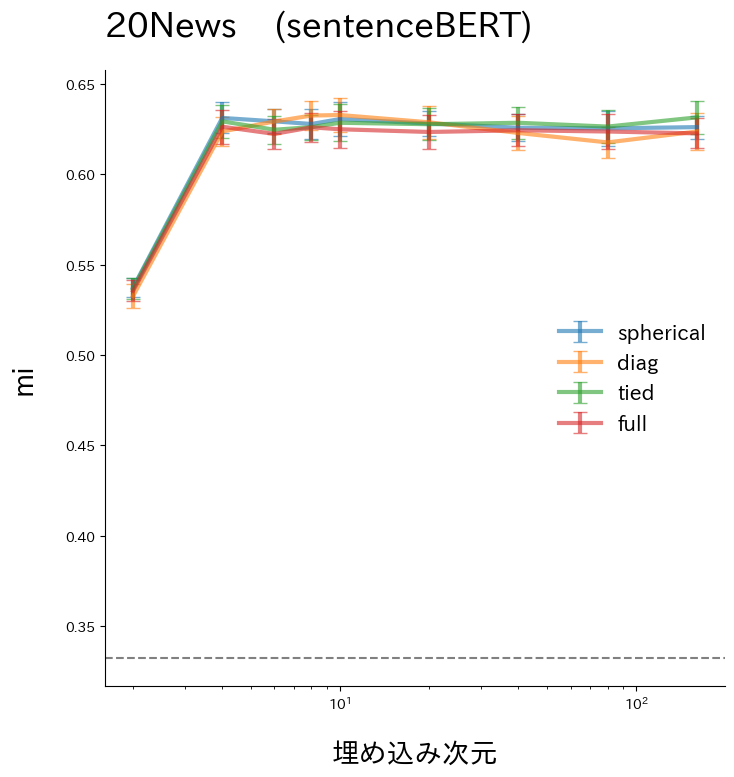

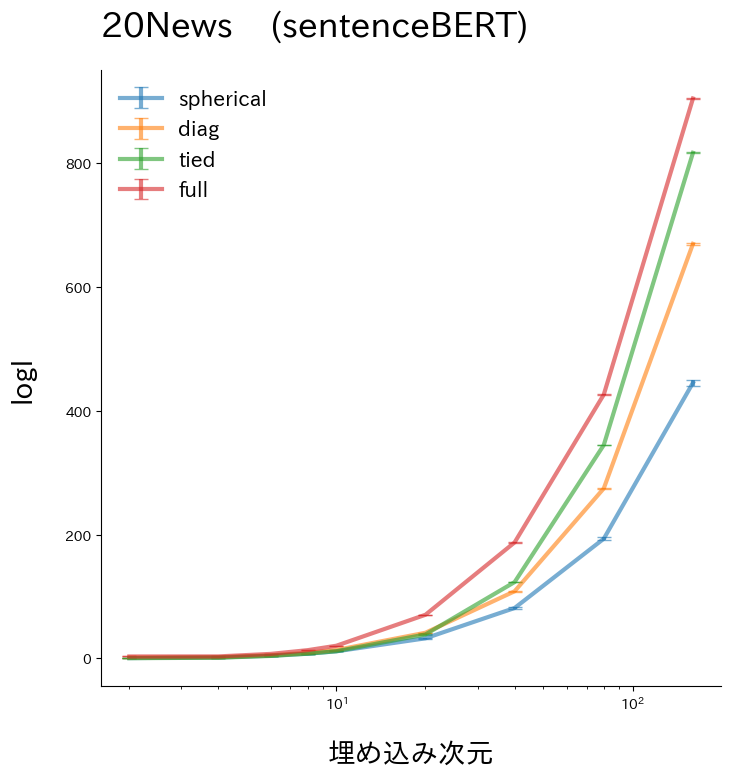

In [16]:
for stats_val in stats_vals:

    fig = plt.figure(**layout["figure"])
    ax = fig.add_subplot(111)
    fig_path = (
        f"../data/figure/{data_type}/{vectorize_type}/GMM/stats/{stats_val}.pdf"
    )
    ax.set_xscale("log")
    line_plot_error_1(
        data[stats_val]["mean"],
        error_low=data[stats_val]["std"],
        error_upper=data[stats_val]["std"],
        fig=fig,
        ax=ax,
        layout=layout,
        title=f"{data_type}    ({vectorize_type})",
        xlabel="埋め込み次元",
        ylabel=stats_val,
        path=fig_path,
    )
    if stats_val == "mi":
        ax.axhline(
            y=describe_lda_mi["mean"].to_numpy(), linestyle="dashed", color="gray"
        )